In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/household-power-consumption/household_power_consumption.csv


In [2]:
df = pd.read_csv("/kaggle/input/household-power-consumption/household_power_consumption.csv",  sep=',',
    na_values='?',
    low_memory=False)
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [3]:
numeric_cols = [
    'Global_active_power',
    'Global_reactive_power',
    'Voltage',
    'Global_intensity',
    'Sub_metering_1',
    'Sub_metering_2',
    'Sub_metering_3'
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True, errors='coerce')


df.drop(['Date', 'Time'], axis=1, inplace=True)


df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   Global_active_power    1044506 non-null  float64       
 1   Global_reactive_power  1044506 non-null  float64       
 2   Voltage                1044506 non-null  float64       
 3   Global_intensity       1044506 non-null  float64       
 4   Sub_metering_1         1044506 non-null  float64       
 5   Sub_metering_2         1044506 non-null  float64       
 6   Sub_metering_3         1044506 non-null  float64       
 7   Datetime               1048575 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7)
memory usage: 64.0 MB


In [4]:
df.dropna(inplace=True)
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
Datetime                 0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df['Target'] = (df['Global_active_power'] > 4.0).astype(int)


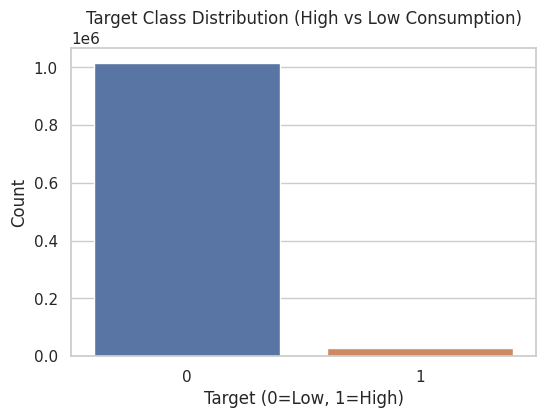

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


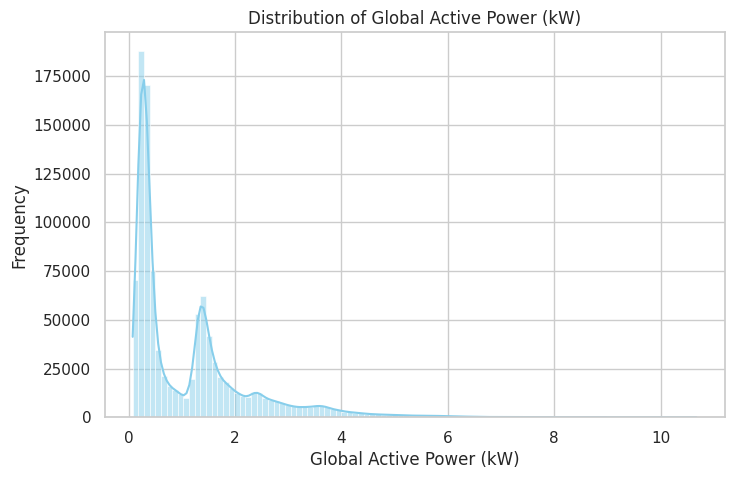

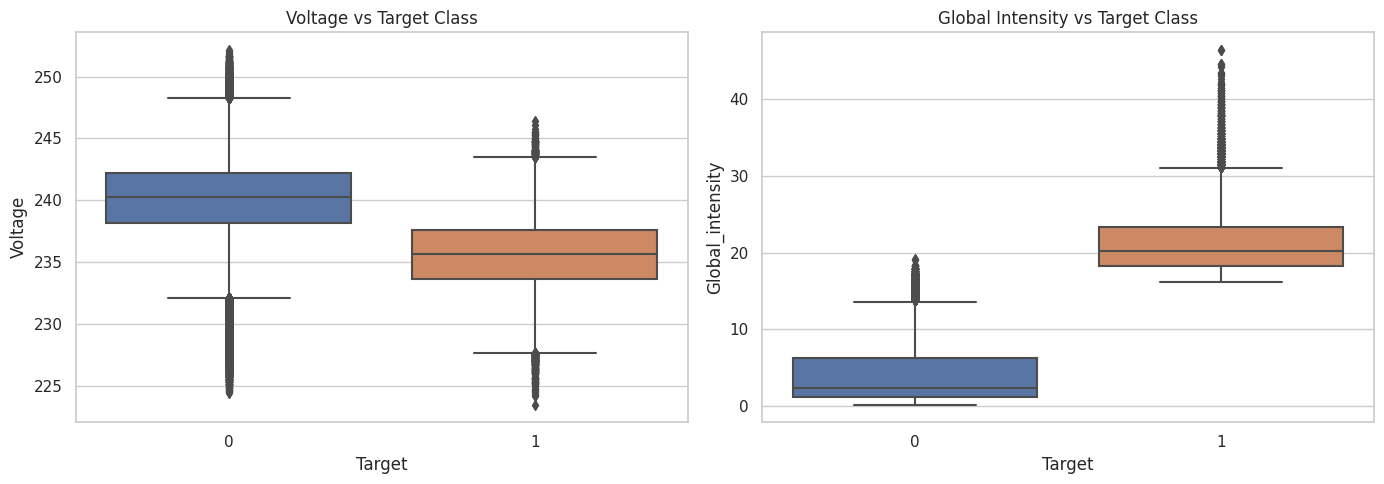

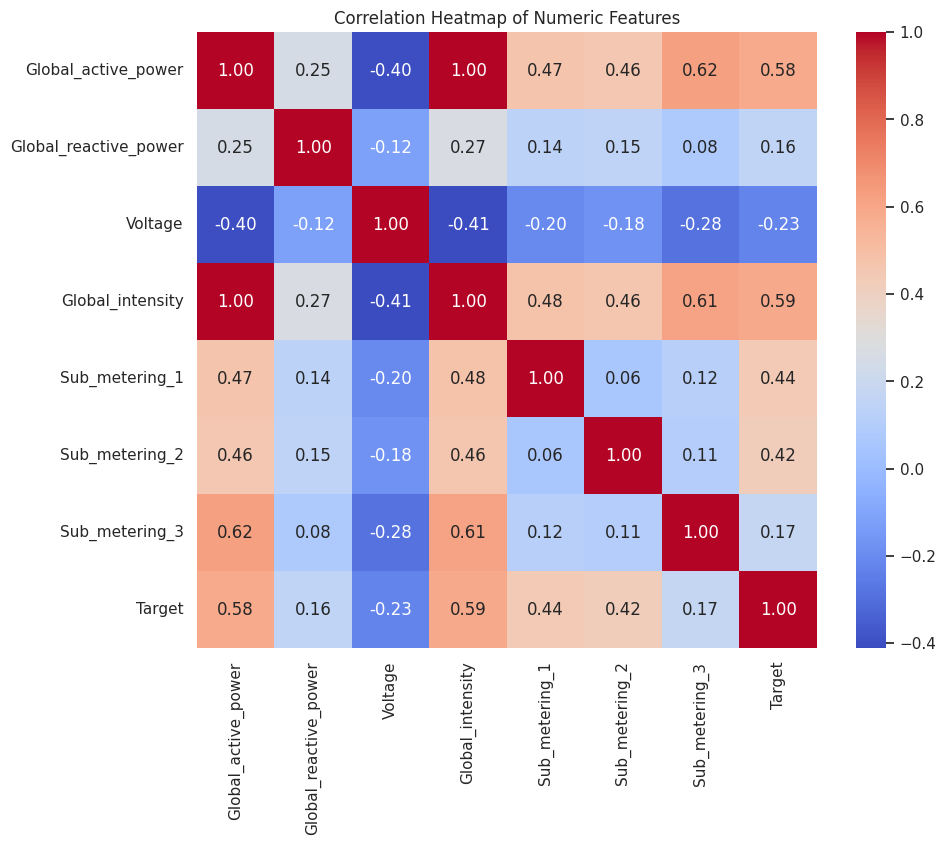

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


plt.figure(figsize=(6, 4))
sns.countplot(x='Target', data=df)
plt.title("Target Class Distribution (High vs Low Consumption)")
plt.xlabel("Target (0=Low, 1=High)")
plt.ylabel("Count")
plt.show()


plt.figure(figsize=(8, 5))
sns.histplot(df['Global_active_power'], bins=100, kde=True, color="skyblue")
plt.title("Distribution of Global Active Power (kW)")
plt.xlabel("Global Active Power (kW)")
plt.ylabel("Frequency")
plt.show()


plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='Target', y='Voltage', data=df)
plt.title("Voltage vs Target Class")

plt.subplot(1, 2, 2)
sns.boxplot(x='Target', y='Global_intensity', data=df)
plt.title("Global Intensity vs Target Class")
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 8))
sns.heatmap(df.drop(columns=['Datetime']).corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1044506 entries, 0 to 1048574
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   Global_active_power    1044506 non-null  float64       
 1   Global_reactive_power  1044506 non-null  float64       
 2   Voltage                1044506 non-null  float64       
 3   Global_intensity       1044506 non-null  float64       
 4   Sub_metering_1         1044506 non-null  float64       
 5   Sub_metering_2         1044506 non-null  float64       
 6   Sub_metering_3         1044506 non-null  float64       
 7   Datetime               1044506 non-null  datetime64[ns]
 8   Target                 1044506 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 79.7 MB


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

X = df.drop(['Datetime', 'Target'], axis=1)
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)


y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]


acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

(acc, report, conf_matrix, (fpr, tpr), roc_auc)

(0.9994351418368421,
 '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00    203050\n           1       0.99      0.99      0.99      5852\n\n    accuracy                           1.00    208902\n   macro avg       1.00      0.99      0.99    208902\nweighted avg       1.00      1.00      1.00    208902\n',
 array([[202994,     56],
        [    62,   5790]]),
 (array([0.        , 0.        , 0.        , ..., 0.99991628, 0.99992613,
         1.        ]),
  array([0.        , 0.47778537, 0.48855092, ..., 1.        , 1.        ,
         1.        ])),
 0.9999904573840861)

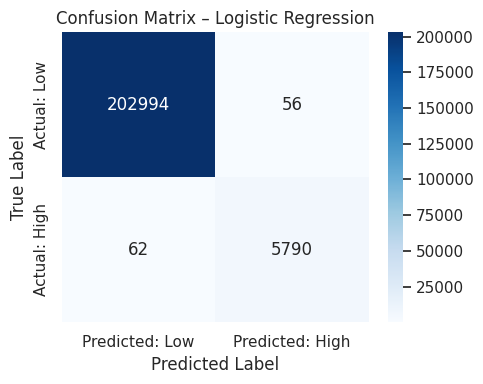

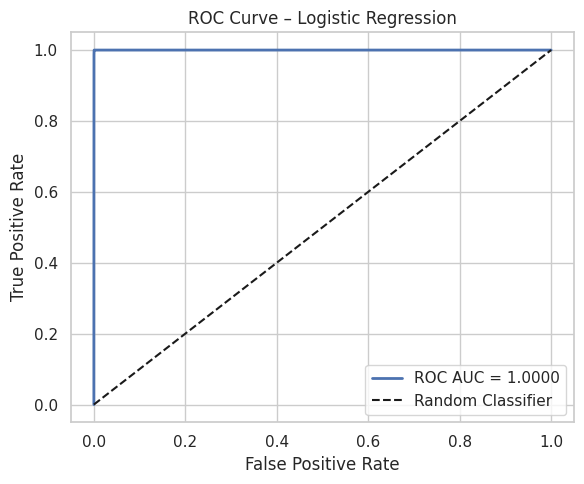

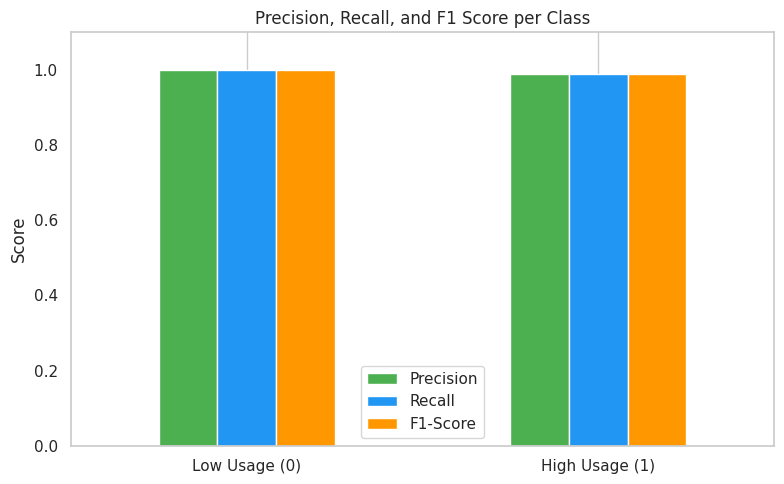

In [10]:

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted: Low', 'Predicted: High'],
            yticklabels=['Actual: Low', 'Actual: High'])
plt.title("Confusion Matrix – Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}, index=['Low Usage (0)', 'High Usage (1)'])

metrics_df.plot(kind='bar', figsize=(8, 5), color=['#4CAF50', '#2196F3', '#FF9800'])
plt.title("Precision, Recall, and F1 Score per Class")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0.0, 1.1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [11]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_train, y_train)


y_pred_tree = tree.predict(X_test)
y_prob_tree = tree.predict_proba(X_test)[:, 1]


acc_tree = accuracy_score(y_test, y_pred_tree)
report_tree = classification_report(y_test, y_pred_tree)
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_prob_tree)
roc_auc_tree = roc_auc_score(y_test, y_prob_tree)

(acc_tree, report_tree, conf_matrix_tree, (fpr_tree, tpr_tree), roc_auc_tree)


(1.0,
 '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00    203050\n           1       1.00      1.00      1.00      5852\n\n    accuracy                           1.00    208902\n   macro avg       1.00      1.00      1.00    208902\nweighted avg       1.00      1.00      1.00    208902\n',
 array([[203050,      0],
        [     0,   5852]]),
 (array([0., 0., 1.]), array([0., 1., 1.])),
 1.0)

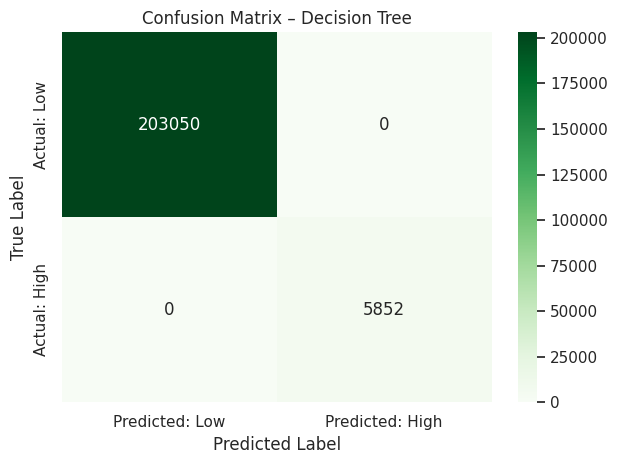

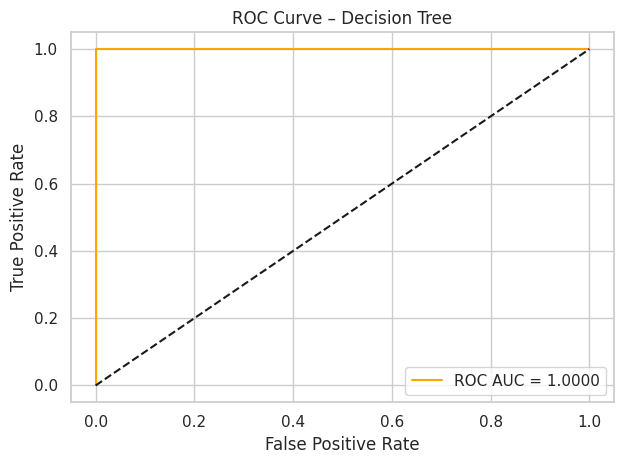

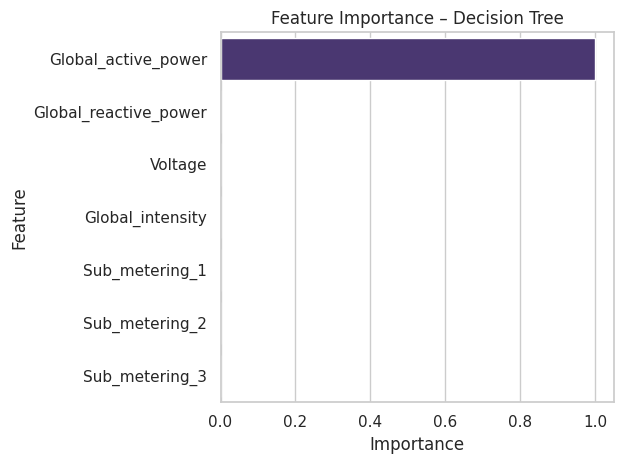

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score

sns.heatmap(conf_matrix_tree, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted: Low', 'Predicted: High'],
            yticklabels=['Actual: Low', 'Actual: High'])
plt.title("Confusion Matrix – Decision Tree")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


fpr_tree, tpr_tree, _ = roc_curve(y_test, y_prob_tree)
roc_auc_tree = roc_auc_score(y_test, y_prob_tree)

plt.plot(fpr_tree, tpr_tree, label=f"ROC AUC = {roc_auc_tree:.4f}", color='orange')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve – Decision Tree")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

feat_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': tree.feature_importances_
}).sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feat_importance, palette='viridis')
plt.title("Feature Importance – Decision Tree")
plt.tight_layout()
plt.show()


In [13]:
df.to_csv("power_consumption.csv")